In [99]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
import numpy as np
import random
import math
import EoN
import seaborn as sns
import time

# New Imports
#from ctrace.contact_tracing import *
#from ctrace.constraint import *
#from ctrace.solve import *
#from ctrace.simulation import *
#from ctrace.restricted import *
from ctrace.simulation import *
from ctrace.dataset import *
from ctrace.recommender import *
from ctrace.problem_label import *
from ctrace.utils import *
from ctrace.drawing import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
# rng = np.random.default_rng()

# def pct_to_int(amt, pcts):
#     """
#     Distributes amt according to pcts. Last element accumulates all fractions, may be off by (n - 1)
#     """
#     first = [int(amt * pct) for pct in pcts[:-1]]
#     return first + [amt - sum(first)]
# assert pct_to_int(10, [0.5, 0.5]) == [5, 5]
# assert pct_to_int(11, [0.5, 0.5]) == [5, 6]
# assert pct_to_int(20, [0.33, 0.33, 0.34]) == [6, 6, 8]

# def segmented_greedy(state: InfectionState, split_pcts=[0.75, 0.25], alloc_pcts=[.25, .75], rng=np.random, overflow=True, DEBUG=False):
#     """
#     pcts are ordered from smallest degree to largest degree
#     split_pcts: segment size percentages
#     alloc_pcts: segment budget percentages
    
#     Overflow Mechanic: the budget may exceed the segment size.
#     We fill from right to left 
#     (greater chance of overflow: larger degree usually have fewer members but higher budget), 
#     and excess capacity is carried over to the next category.
#     """
#     if not math.isclose(1, sum(split_pcts)):
#         raise ValueError(f"split_pcts '{split_pcts}' sum to {sum(split_pcts)}, not 1")
#     if not math.isclose(1, sum(alloc_pcts)):
#         raise ValueError(f"alloc_pcts '{alloc_pcts}' sum to {sum(alloc_pcts)}, not 1")
    
#     budget = state.budget
#     G = state.G
#     split_amt = pct_to_int(len(state.V1), split_pcts)
#     alloc_amt = pct_to_int(budget, alloc_pcts)
    
#     v1_degrees = [(n, G.degree(n)) for n in state.V1]
#     v1_sorted = [n for n,d in sorted(v1_degrees, key=lambda x: x[1])]
    
#     v1_segments = np.split(v1_sorted, np.cumsum(split_amt[:-1]))
    
#     overflow = 0
#     samples = []
#     for segment, amt in reversed(list(zip(v1_segments, alloc_amt))):
#         # Overflow is carried over to the next segment
#         segment_budget = amt + overflow
#         if segment_budget > len(segment):
#             overflow = segment_budget - len(segment)
#             segment_budget = len(segment)
#         else:
#             overflow = 0
            
#         sample = rng.choice(segment, segment_budget, replace=False)
#         samples.extend(sample)
        
#         if DEBUG:
#             print(f"{segment_budget} / {len(segment)} (overflow: {overflow})")
#             print("segment: ", segment)
#             print("sample: ", sample)
#             print("--------------")
#             assert len(samples) <= budget
#     return samples


### Smallworld Graphs

In [101]:
import random
import networkx as nx
from matplotlib import pyplot as plt

# Graph Generation
seed=42
# G, pos = small_world_grid(
#     width=20,
#     max_norm=True,
#     sparsity=0.5,
#     p=1,
#     local_range=1,
#     num_long_range=0.2,
#     r=2,
#     seed=seed
# )

# BORING
G, pos = small_world_grid(
    width=10,
    max_norm=False,
    sparsity=0,
    p=1,
    local_range=1,
    num_long_range=0,
    r=2,
    seed=seed
)


for n in G.nodes:
    G.nodes[n].update({
        'compliance_rate_og': 1,
        'age_group': 1,
    })
for e in G.edges:
    G.edges[e].update({
        'duration': 10000,
    })

100%|██████████| 100/100 [00:00<00:00, 5138.13it/s]


In [105]:
# I1 = E
# I2 = I

min_cut_node_style = {
    # Default styling
    "default": {
        "node_size": 30,
        "node_color": "black",
        "edgecolors": "black",
        "linewidths": 0.5,
    },
    "seir": {
        SEIR.E: {"node_size": 60, "node_color": "red"},
        SEIR.I: {"node_size": 60, "node_color": "darkred"},
        SEIR.R: {"node_size": 60, "node_color": "skyblue"},
    },
    "isolate": {
        True: {"edgecolors": "aqua", "linewidths": 1.5}
    },
#     "V1": {
#         True: {"node_size": 30, "node_color": "orange"},
#     }
}

min_cut_edge_style = {
    # connectionstyle and arrowstyle are function-wide parameters
    # NOTE: For limit the number of unique connectionstyle / arrowstyle pairs
    "default": {
        "edge_color": "black",
        "arrowstyle": "-",
    },
    "long": {
        False: {},
        True: {"connectionstyle": "arc3,rad=0.2"},
    },

    # Overriding (cut overrides transmission)
    "transmit": {
        False: {},
        True: {"edge_color": "red"},
    },
    "cut": {
        False: {},
        True: {"edge_color": "blue"},
    },
}

min_cut_node_style

{'default': {'node_size': 30,
  'node_color': 'black',
  'edgecolors': 'black',
  'linewidths': 0.5},
 'seir': {<SEIR.E: 2>: {'node_size': 60, 'node_color': 'red'},
  <SEIR.I: 3>: {'node_size': 60, 'node_color': 'darkred'},
  <SEIR.R: 4>: {'node_size': 60, 'node_color': 'skyblue'}},
 'isolate': {True: {'edgecolors': 'aqua', 'linewidths': 1.5}}}

In [108]:
# Run the simulation
rng = np.random.default_rng(12345)
i1_pct = 0.0
i2_pct = 0.15
seir = PartitionSEIR.from_dist(len(G), [1 - i1_pct - i2_pct, i1_pct, i2_pct, 0], rng=rng)
state = InfectionState(
    G=G, 
    SIR=(list(seir.S), list(seir.E), list(seir.I), list(seir.R)), 
    budget=int(len(G) * 0.3), 
    policy="none", 
    transmission_rate=0.15, 
    transmission_known=True, 
    compliance_rate=1, 
    compliance_known=True, 
    discovery_rate=1, 
    snitch_rate=1
)
action = segmented_greedy(state)
print(f"G size: {len(G)}")
print(f"action ({len(action)}): {action}")
print(f"V1 ({len(state.V1)}): {state.V1}")
print("action = V1: ", set(action) == set(state.V1))
print("G size", len(G))

G size: 100
action (17): [75, 53, 82, 83, 86, 84, 87, 47, 71, 14, 31, 20, 95, 38, 12, 42, 24]
V1 (35): {7, 12, 13, 14, 17, 18, 20, 22, 24, 25, 27, 31, 33, 36, 38, 40, 42, 44, 45, 47, 53, 60, 71, 75, 80, 82, 83, 84, 86, 87, 91, 94, 95, 96, 98}
action = V1:  False
G size 100


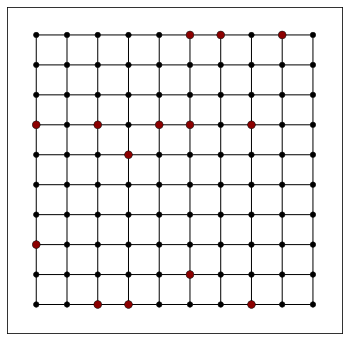

In [104]:
fig, ax = plt.subplots(figsize=(6,6))
nx.set_node_attributes(G, seir.to_dict(), "seir")
fast_draw_style(G, min_cut_node_style,
           min_cut_edge_style, ax=ax, DEBUG=False)
plt.show()

In [ ]:
import copy
raw_history = []
state_history = []
action_history = []

def pct_format(name, v1, v2):
    pct = f"{(v1 / v2) * 100:.1f}%" if v2 != 0 else "-%"
    return f"{name}: {v1}/{v2} ({pct})"

while len(state.SIR.I2) + len(state.SIR.I1)!=0:
    action = segmented_greedy(state)
    
    state_history.append(state.SIR)
    action_history.append(action)
    raw_history.append(copy.deepcopy(state))
    
    print(f"Size (I1, I2, I): {(len(state.SIR.I1), len(state.SIR.I2), len(state.SIR.I1) + len(state.SIR.I2))}")
    print(f"V1 Size: {len(state.V1)}")
    print(f"V2 Size: {len(state.V2)}")
    print(pct_format("Utilized Quarantine (out of V1)", len(action), len(state.V1)))
    print(pct_format("I1 Quarantined (out of Q)", len(set(state.V1) & set(action)), len(action)))
    print(f"I1: {state.SIR.I1}")
    print(f"I2: {state.SIR.I2}")
    print(f"V1: {state.V1}")
    print(f"V2: {state.V2}")
    print(f"Q: {action}")
    print("-----------------------------")
    
    # Mutable state
    state.step(action)

action_history.append(set())

In [ ]:
G_draw = G.copy()
seir = PartitionSEIR.from_sets(state_history[0])
action = {n: True for n in action_history[0]}
nx.set_node_attributes(G_draw, seir.to_dict(), "seir")
nx.set_node_attributes(G_draw, action, "isolate")
transmit = {e: (seir[e[0]] == SEIR.E or seir[e[0]] == SEIR.I) or (seir[e[1]] == SEIR.E or seir[e[1]] == SEIR.I)
            for e in G_draw.edges}
nx.set_edge_attributes(G_draw, transmit, "transmit")


In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

fast_draw_style(G_draw, min_cut_node_style,
           min_cut_edge_style, ax=ax, DEBUG=False)
nx.draw_networkx_labels(G_draw, pos, font_size=10, ax=ax, verticalalignment='bottom', horizontalalignment="right")
plt.show()

In [ ]:
for s in state_history:
    print([s.I1, s.I2])
    print('-----------------')

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation

# Build plot
fig, ax = plt.subplots(figsize=(10,10))


def update(num, SIR=([],[],[]), v1_edges=[]):
    ax.clear()
    
    G_draw = G.copy()
    
    state = raw_history[num]
    
    seir = PartitionSEIR.from_sets(state_history[num])
    nx.set_node_attributes(G_draw, seir.to_dict(), "seir")
    
    action = {n: True for n in action_history[num]}    
    nx.set_node_attributes(G_draw, action, "isolate")
    
    transmit = {e: (seir[e[0]] == SEIR.E or seir[e[0]] == SEIR.I) or (seir[e[1]] == SEIR.E or seir[e[1]] == SEIR.I)
                for e in G_draw.edges}
    nx.set_edge_attributes(G_draw, transmit, "transmit")
    
    nx.set_node_attributes(G_draw, {n: True for n in state.V1}, "V1")
    nx.set_node_attributes(G_draw, {n: True for n in state.V2}, "V2")
#     nx.set_node_attributes(rand_G, vertex_soln, "status")
#     nx.set_edge_attributes(rand_G, edge_soln, "cut")

#     transmit = {e: vertex_soln[e[0]] or vertex_soln[e[1]]
#                 for e in rand_G.edges}
#     nx.set_edge_attributes(rand_G, transmit, "transmit")

    fast_draw_style(G_draw, min_cut_node_style,
               min_cut_edge_style, ax=ax, DEBUG=False)
    nx.draw_networkx_labels(G_draw, pos, font_size=10, ax=ax, verticalalignment='bottom', horizontalalignment="right")
    
    # Scale plot ax
    ax.set_title(f"Frame {num}", fontweight="bold")
    ax.set_xticks([])
    ax.set_yticks([])

ani = matplotlib.animation.FuncAnimation(fig, update, frames=len(state_history), interval=500, repeat=True, repeat_delay=1)

In [ ]:
action_history

In [ ]:
from IPython.display import HTML
html_out = ani.to_jshtml()
HTML(html_out)


In [ ]:
ani.save('sim.mp4', dpi=200, fps=.5)

In [ ]:
with open('viz_large.html', 'w+') as f:
    f.write(html_out)

In [ ]:
G_mont = load_graph_montgomery_labels()


In [ ]:
G_mont.nodes[0]

In [ ]:
G_mont.edges[(0,1)]

In [ ]:
with open(PROJECT_ROOT / "data" / "SIR_Cache" / "c7.json", 'r') as infile:
    j = json.load(infile)
    (S, I1, I2, R) = (j["S"], j["I1"], j["I2"], j["R"])
    infections = j["infections"]

In [ ]:


state = InfectionState(G, (S, I1, I2, R), 1000, "none", 0.05, True, 0.8, True, 1, 1)

while len(state.SIR.I2) + len(state.SIR.I1)!=0:
    state.step(DepRound_fair(state))
    print(len(state.SIR.R))